In [39]:
from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
from astropy.convolution import convolve_fft
from astropy.stats import mad_std
import numpy as np
from radio_beam import Beam
from reproject import reproject_interp
from matplotlib import pyplot as plt
from scipy.ndimage import binary_dilation
from astropy.modeling import models, fitting
from astropy.table import Table, vstack 
from glob import glob 
from synphot import SpectralElement, units
import os

import warnings 
warnings.filterwarnings('ignore')

# Loading files

In [40]:
def get_hdu(rootdir, filename, hdu_id=0, return_filename=False):
    filename_full = glob(rootdir+filename)[0]
    if hdu_id == 'all':
        hdu = fits.open(filename_full)
    else:
        hdu = fits.open(filename_full)[hdu_id]
    print(filename_full)

    if return_filename: 
        return(hdu, filename_full)
    else:  
        return(hdu)

galaxy = 'ngc628c'
galaxy_muse = 'ngc0628'
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/%s/' %galaxy
rootdir_bp = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/' 

narrowband_filter = 'f658n'
instrument_f555w  = 'acs'
instrument_f65Xn = 'acs'
instrument_f814w = 'acs'

hdu_muse_f555w  = get_hdu(rootdir, 'muse/%s*_%s_*F555W.fits' %(galaxy_muse.upper(), instrument_f555w.upper()))
hdu_muse_f65Xn  = get_hdu(rootdir, 'muse/%s*_%s_*%s.fits' %(galaxy_muse.upper(), instrument_f65Xn.upper(), narrowband_filter.upper()))
hdu_muse_f814w  = get_hdu(rootdir, 'muse/%s*_%s_*F814W.fits' %(galaxy_muse.upper(), instrument_f814w.upper()))
hdu_muse_stars  = get_hdu(rootdir, 'muse/%s_starmask.fits' %galaxy_muse.upper())
hdu_muse_neb    = get_hdu(rootdir, 'muse/%s_nebmask.fits' %galaxy_muse.upper())
hdu_muse        = get_hdu(rootdir, 'muse/%s*_MAPS.fits' %galaxy_muse.upper(), 'all')

hdu_hst_f555w   = get_hdu(rootdir, 'hst/%s*_%s_*f555w*.fits' %(galaxy, instrument_f555w))
hdu_hst_f65Xn   = get_hdu(rootdir, 'hst/%s*_%s_*%s*.fits' %(galaxy, instrument_f65Xn, narrowband_filter))
hdu_hst_f814w   = get_hdu(rootdir, 'hst/%s*_%s_*f814w*.fits' %(galaxy, instrument_f814w))

hst_res  = 0.07 * u.arcsec
_, file_muse_f65Xn = get_hdu(rootdir, 'muse/%s*_%s_*%s.fits' %(galaxy_muse.upper(), instrument_f65Xn.upper(), narrowband_filter.upper()), return_filename=True)
muse_res = np.float32(file_muse_f65Xn.split('asec')[0].split('-')[-1]) * u.arcsec

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628-0.92asec_ACS_F555W.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628-0.92asec_ACS_F658N.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628-0.92asec_ACS_F814W.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628_starmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628-0.92asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst/ngc628c_acs_f555w_exp_drc_sci.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst/ngc628c_acs_f658n_exp_drc_sci.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst/ngc628c_acs_f814w_exp_drc_sci.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_h

In [41]:
def make_paths(rootdir):
    
    print('[Info] Outputing to the following:')
    print(rootdir+'hst_contsub_unittest')

    if not os.path.isdir(rootdir+'hst_contsub_unittest'):
        os.mkdir(rootdir+'hst_contsub_unittest')  
    if not os.path.isdir(rootdir+'hst_contsub_unittest/figs'):
        os.mkdir(rootdir+'hst_contsub_unittest/figs')
    os.system('rm -rf '+rootdir+'hst_contsub_unittest/*.fits')

make_paths(rootdir)

[Info] Outputing to the following:
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub_unittest


In [42]:
def get_bandpassinfo(files):

    files.sort()

    bp = {}
    for file in files:

        print(file)

        area = 45238.93416 * units.AREA  # HST
        bp_ = SpectralElement.from_file(file)
        name = file.split('/')[-1].split('.dat')[0].replace('HST_', '').replace('.F', '_F')
        name = name.replace('WFC_', '')
        name = name.replace('WFC3_', '')
        name = name.replace('UVIS1', 'UVIS')

        bp[name] = {'equivwidth': bp_.equivwidth().value, 
                    'integrate': bp_.integrate().value, 
                    'rmswidth': bp_.rmswidth().value, 
                    'photbw': bp_.photbw().value, 
                    'fwhm': bp_.fwhm().value, 
                    'rectwidth': bp_.rectwidth().value, 
                    'pivot': bp_.pivot().value, 
                    'unit_response': bp_.unit_response(area).value}  
    
    return(bp)

files_bp = glob('%s*.dat' %rootdir_bp)
bp = get_bandpassinfo(files_bp)
bp.keys()

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F550M.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F555W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F658N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F814W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F555W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F657N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F658N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F814W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS2.F547M.dat


dict_keys(['ACS_F550M', 'ACS_F555W', 'ACS_F658N', 'ACS_F814W', 'UVIS_F555W', 'UVIS_F657N', 'UVIS_F658N', 'UVIS_F814W', 'UVIS2_F547M'])

# Correct units 
HST -> electron/s to ergcm2sA 
MUSE - > Jy to ergcm2sA

In [43]:
def get_nanzeros(hdu):
    hdu.data[hdu.data == 0] = np.nan
    return(hdu)

hdu_hst_f555w = get_nanzeros(hdu_hst_f555w)
hdu_hst_f65Xn = get_nanzeros(hdu_hst_f65Xn)
hdu_hst_f814w = get_nanzeros(hdu_hst_f814w)

In [44]:
def get_electrons_2_ergcm2sA(hdu, photflam=None, photplam=None, photbw=None):

    data = hdu.data.copy()

    if photflam == None: 

        # Get the necessary header keywords for scaling and conversion
        photflam = hdu.header['PHOTFLAM']
        photplam = hdu.header['PHOTPLAM']
        photbw = hdu.header['PHOTBW']
    
    # Scale the data using photflam and photbw
    data_conv = data * photflam

    hdu.data = np.array(data_conv, dtype=np.float32) *1e20
    hdu.header['BUNIT'] = ('erg/s/cm2/A/pixel', '1e-20 erg/s/cm2/A')

    return(hdu)

hdu_hst_f555w = get_electrons_2_ergcm2sA(hdu_hst_f555w)
hdu_hst_f65Xn = get_electrons_2_ergcm2sA(hdu_hst_f65Xn)
hdu_hst_f814w = get_electrons_2_ergcm2sA(hdu_hst_f814w)

In [45]:
photflam_tab_f555w

1.9879003625253695e-19

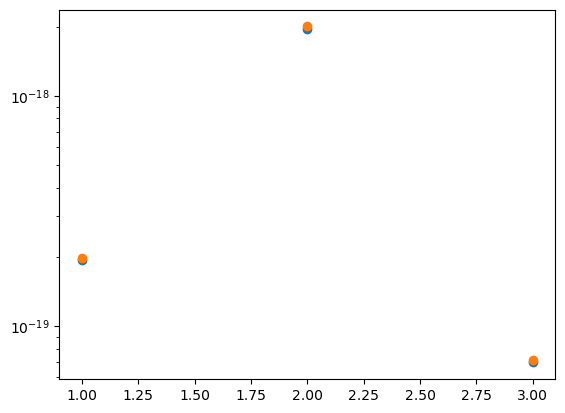

In [46]:
photflam_hdr_f555w = hdu_hst_f555w.header['PHOTFLAM']
photflam_hdr_f65Xn = hdu_hst_f65Xn.header['PHOTFLAM']
photflam_hdr_f814w = hdu_hst_f814w.header['PHOTFLAM']

photflam_tab_f555w = bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['unit_response']
photflam_tab_f65Xn = bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['unit_response']
photflam_tab_f814w = bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['unit_response']

plt.scatter([1,2,3], [photflam_hdr_f555w,photflam_hdr_f65Xn,photflam_hdr_f814w])
plt.scatter([1,2,3], [photflam_tab_f555w,photflam_tab_f65Xn,photflam_tab_f814w])
plt.yscale('log')

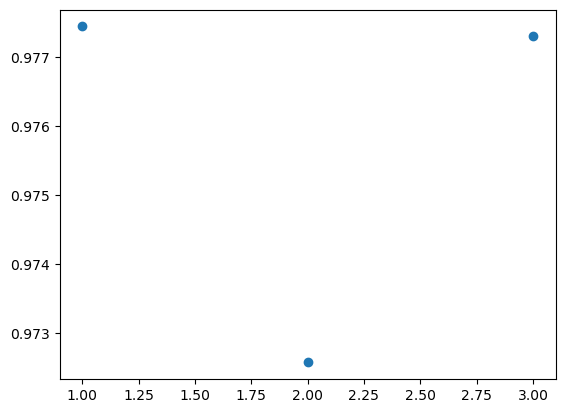

In [47]:
plt.scatter([1,2,3], [photflam_hdr_f555w/photflam_tab_f555w,photflam_hdr_f65Xn/photflam_tab_f65Xn,photflam_hdr_f814w/photflam_tab_f814w])

In [48]:
def get_Jy_2_ergcm2sA(hdu, photplam):

    data = hdu.data.copy()
    
    w = photplam * u.AA
    a = 1. * u.Jy
    b = a.to(u.erg / u.cm**2 / u.s / u.AA, u.spectral_density(w))
    data_conv = data * b.value

    hdu.data = np.array(data_conv, dtype=np.float32) *1e20
    hdu.header['BUNIT'] = ('erg/s/cm2/A/pixel', '1e-20 erg/s/cm2/A')

    return(hdu)

hdu_muse_f555w = get_Jy_2_ergcm2sA(hdu_muse_f555w, bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'])
hdu_muse_f65Xn = get_Jy_2_ergcm2sA(hdu_muse_f65Xn, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'])
hdu_muse_f814w = get_Jy_2_ergcm2sA(hdu_muse_f814w, bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])

# Smoothing and Regridding
Smoothing and regridding HST to MUSE 

In [49]:
def get_smooth(hdu, initial_resolution, desired_resolution):
    
    # Create a WCS object from the input HDU header
    wcs_ = wcs.WCS(hdu.header)

    # Calculate the pixel scale in degrees
    pixscale = wcs.utils.proj_plane_pixel_area(wcs_.celestial) ** 0.5 * u.deg
    print(f"[INFO] Pixel scale: {pixscale.to('arcsec'):.2f} arcsec")

    # Define the initial and desired beams
    initial_beam = Beam(initial_resolution)
    desired_beam = Beam(desired_resolution)

    print(f"[INFO] Initial Resolution: {initial_resolution.to('arcsec'):.2f} arcsec")
    print(f"[INFO] Desired Resolution: {desired_resolution.to('arcsec'):.2f} arcsec")
    
    # Create the convolution kernel
    convolution_beam = (desired_resolution.to('arcsec')**2 - initial_resolution.to('arcsec')**2)**0.5
    convolution_kernel = desired_beam.deconvolve(initial_beam).as_kernel(pixscale)
    print(f"[INFO] Convolution kernel: {convolution_beam.to('arcsec'):.2f} arcsec")

    # Convolve the image with the kernel to smooth it
    print("[INFO] Performing image convolution...")
    smoothed_data = convolve_fft(hdu.data, convolution_kernel, preserve_nan=True, allow_huge=True)
    print("[INFO] Image convolution complete.")

    output_hdu = fits.PrimaryHDU(np.array(smoothed_data, dtype=np.float32), hdu.header)

    print("[INFO] Smoothing process completed.")
    return(output_hdu)

hdu_hst_f555w_sm = get_smooth(hdu_hst_f555w, hst_res, muse_res)
hdu_hst_f65Xn_sm = get_smooth(hdu_hst_f65Xn, hst_res, muse_res)
hdu_hst_f814w_sm = get_smooth(hdu_hst_f814w, hst_res, muse_res)

[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.07 arcsec arcsec
[INFO] Desired Resolution: 0.92 arcsec arcsec
[INFO] Convolution kernel: 0.92 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Smoothing process completed.
[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.07 arcsec arcsec
[INFO] Desired Resolution: 0.92 arcsec arcsec
[INFO] Convolution kernel: 0.92 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Smoothing process completed.
[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.07 arcsec arcsec
[INFO] Desired Resolution: 0.92 arcsec arcsec
[INFO] Convolution kernel: 0.92 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Smoothing process completed.


In [50]:
def get_regrid(hdu_input, hdu_template, output_filename=None, conserve_flux=True, order='bilinear'):

    print("[INFO] Reprojecting the input image to match the template WCS...")

    # Extract the WCS information from the input and template headers
    wcs_input = wcs.WCS(hdu_input.header)
    wcs_template = wcs.WCS(hdu_template.header)

    # Calculate the pixel scale for input and template images
    pixscale_input = wcs.utils.proj_plane_pixel_area(wcs_input.celestial)
    pixscale_template = wcs.utils.proj_plane_pixel_area(wcs_template.celestial)

    # Reproject the input image to match the template WCS
    print("[INFO] Performing image reprojection...")
    # data_output = reproject_interp(hdu_input, hdu_template.header, order=0, parallel=True)[0]
    # data_output = reproject_interp(hdu_input, hdu_template.header, order=0)[0]
    data_output = reproject_interp(hdu_input, hdu_template.header, order=order)[0]
    hdu_output = fits.PrimaryHDU(data_output, hdu_template.header)
    print("[INFO] Image reprojection complete.")

    if conserve_flux:
        # Scale the output data to conserve flux 
        print(f"[INFO] Scaling the output data to conserve flux with factor {(pixscale_template / pixscale_input):.2f}")
        hdu_output.data = hdu_output.data * (pixscale_template / pixscale_input)
        hdu_output.data = np.array(hdu_output.data, dtype=np.float32)
        print("[INFO] Flux scaling complete.")

    print("[INFO] Reprojection process completed.")
    return(hdu_output)

hdu_hst_f555w_smre = get_regrid(hdu_hst_f555w_sm, hdu_muse_f555w)
hdu_hst_f65Xn_smre = get_regrid(hdu_hst_f65Xn_sm, hdu_muse_f65Xn)
hdu_hst_f814w_smre = get_regrid(hdu_hst_f814w_sm, hdu_muse_f814w)

[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.


# Flux scaling
Scaling flux of HST to MUSE with linear fits

In [51]:
def get_anchoring(hdu1, hdu2, hdu3, hdu_stars, filter='', make_plots=True):

    hdu1 = hdu1.copy()
    hdu2 = hdu2.copy()
    hdu3 = hdu3.copy()

    data1 = hdu1.data.copy()
    data2 = hdu2.data.copy()

    # Mask zeros 
    mask_zero1 = data1==0
    mask_zero2 = data2==0
    data1[(mask_zero1&mask_zero2)] = np.nan
    data2[(mask_zero1&mask_zero2)] = np.nan

    # Mask with starmask 
    mask_stars = hdu_stars.data!=0
    data1[mask_stars] = np.nan
    data2[mask_stars] = np.nan

    # Mask with RMS 
    rms = mad_std(data1, ignore_nan=True)
    # rms = mad_std(data1[data1<rms], ignore_nan=True)
    mask_high = data1 > rms*5
    mask_low = data1 > rms*1
    mask1 = binary_dilation(mask_high, mask=mask_low, iterations=-1)

    rms = mad_std(data2, ignore_nan=True)
    # rms = mad_std(data2[data2<rms], ignore_nan=True)
    mask_high = data2 > rms*5
    mask_low = data2 > rms*1
    mask2 = binary_dilation(mask_high, mask=mask_low, iterations=-1)

    data1[~mask1] = np.nan
    data2[~mask2] = np.nan

    valid_indices = np.isfinite(data1) & np.isfinite(data2)
    x_data = data1[valid_indices]
    y_data = data2[valid_indices]

    # Mask with STD 
    # std = 34.1+13.6+2.1
    std = 49.73
    x_per = np.percentile(x_data, [50-std, 50+std])
    y_per = np.percentile(y_data, [50-std, 50+std])

    x_mask = (x_data>x_per[0])&(x_data<x_per[1])
    y_mask = (y_data>y_per[0])&(y_data<y_per[1])

    # Mask with STD 
    ratio = x_data/y_data
    r_mask = (ratio>0.33)&(ratio<3)

    x_data_fit = x_data[(x_mask&y_mask&r_mask)]
    y_data_fit = y_data[(x_mask&y_mask&r_mask)]

    x_data_nofit = x_data[~(x_mask&y_mask&r_mask)]
    y_data_nofit = y_data[~(x_mask&y_mask&r_mask)]

    # Calculate a line of best fit for the data
    # slope, intercept = np.polyfit(x_data, y_data, 1)
    model_poly = models.Polynomial1D(degree=1)
    fitter_poly = fitting.LinearLSQFitter() 
    best_fit_poly = fitter_poly(model_poly, x_data_fit, y_data_fit)
    intercept, slope = best_fit_poly.parameters

    x_fit = np.linspace(np.min(x_data), np.max(x_data), 10000)
    y_fit = slope * x_fit + intercept
    # print(f"[INFO] xy-fit --- slope: {slope}, intercept: {intercept}")

    # Extract the WCS information from the input and template headers
    wcs1 = wcs.WCS(hdu1.header)
    wcs3 = wcs.WCS(hdu3.header)
    pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
    pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

    pixscale_ratio = (pixscale3 / pixscale1)
    fit = [filter, slope, intercept, intercept*pixscale_ratio]
    print(f"[INFO] xy-fit --- slope: %0.1f, intercept: %0.1f, intercept scaled:  %0.1f" %(slope, intercept, intercept*pixscale_ratio))
    hdu3.data = (hdu3.data - (intercept*pixscale_ratio)) / slope

    if make_plots: 

        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        for ax in [ax1, ax2]:

            ax.scatter(x_data_nofit, y_data_nofit, c='C0', alpha=0.05, s=10)
            ax.scatter(x_data_fit, y_data_fit, c='C1', alpha=0.05, s=10)

            ax.plot(x_fit, best_fit_poly(x_fit), color='k', linewidth=2, 
                    linestyle='--', label=f'y = {slope:.2f}x + {intercept:.2g}')
            ax.plot(x_fit, x_fit, 'k', linewidth=2, linestyle=':', label=f'y = x')

            ax.set_xlabel('Flux density (MUSE) [erg/s/cm-2/A/pix]')
            ax.set_ylabel('Flux density (HST smoothed, regrid) [erg/s/cm-2/A/pix]')
            ax.legend()
            ax.grid(True, ls=':', color='k', alpha=0.2, which='both')

        ax2.set_xscale('log')
        ax2.set_yscale('log')

        plt.tight_layout()
        fig.savefig(rootdir+'hst_contsub_unittest/figs/fit_%s.png' %filter, bbox_inches='tight')
        plt.close('all')

        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        ax1.imshow(data1, vmin=np.nanpercentile(data1, 0.1), vmax=np.nanpercentile(data1, 99), origin='lower', cmap='inferno')
        ax2.imshow(data2, vmin=np.nanpercentile(data2, 0.1), vmax=np.nanpercentile(data2, 99), origin='lower', cmap='inferno')

        hdu1.data[hdu1.data==0] = np.nan
        mask1 = ~np.isnan(hdu1.data)*1
        ax1.contour(mask1, levels=[1], colors='k')

        hdu2.data[hdu2.data==0] = np.nan
        mask2 = ~np.isnan(hdu2.data)*1
        ax2.contour(mask2, levels=[1], colors='k')

        ax1.set_yticks([])
        ax1.set_xticks([])
        ax2.set_yticks([])
        ax2.set_xticks([])

        bbox = dict(boxstyle='round', fc="w", ec="k")
        ax1.text(0.5, 0.95, 'MUSE %s' %filter, transform=ax1.transAxes, va='top', ha='center', bbox=bbox)
        ax2.text(0.5, 0.95, 'HST %s' %filter, transform=ax2.transAxes, va='top', ha='center', bbox=bbox)

        plt.tight_layout()
        fig.savefig(rootdir+'hst_contsub_unittest/figs/masks_%s.png' %filter, bbox_inches='tight')
        plt.close('all')

    return(hdu3, fit)

hdu_hst_f555w_an, fit_f555w = get_anchoring(hdu_muse_f555w, hdu_hst_f555w_smre, hdu_hst_f555w, hdu_muse_stars, 'f555w')
hdu_hst_f65Xn_an, fit_f65Xn = get_anchoring(hdu_muse_f65Xn, hdu_hst_f65Xn_smre, hdu_hst_f65Xn, hdu_muse_stars, narrowband_filter)
hdu_hst_f814w_an, fit_f814w = get_anchoring(hdu_muse_f814w, hdu_hst_f814w_smre, hdu_hst_f814w, hdu_muse_stars, 'f814w')

fit_f555w.append(galaxy)
fit_f65Xn.append(galaxy)
fit_f814w.append(galaxy)

[INFO] xy-fit --- slope: 1.0, intercept: -18.5, intercept scaled:  -0.7
[INFO] xy-fit --- slope: 1.0, intercept: -20.3, intercept scaled:  -0.8
[INFO] xy-fit --- slope: 1.0, intercept: -13.7, intercept scaled:  -0.5


# Continuum subtraction

In [27]:
def get_contsub(hdu_halpha, hdu_cont1, hdu_cont2, 
                photplam_halpha=None, photplam_cont1=None, photplam_cont2=None):

    if photplam_halpha == None:
        photplam_halpha = hdu_halpha.header['PHOTPLAM']
        photplam_cont1 = hdu_cont1.header['PHOTPLAM']
        photplam_cont2 = hdu_cont2.header['PHOTPLAM']

    weight_cont1 = abs(photplam_cont2 - photplam_halpha) / abs(photplam_cont1 - photplam_cont2)
    weight_cont2 = abs(photplam_cont1 - photplam_halpha) / abs(photplam_cont1 - photplam_cont2)

    coef_cont1 = weight_cont1
    coef_cont2 = weight_cont2

    data_cont1 = hdu_cont1.data
    data_cont2 = hdu_cont2.data

    data_cont1[data_cont1<=0] = np.nan
    data_cont2[data_cont2<=0] = np.nan

    data_cont1 = np.log10(data_cont1)
    data_cont2 = np.log10(data_cont2)

    hdu_cont1.data = data_cont1 * coef_cont1
    hdu_cont2.data = data_cont2 * coef_cont2

    data_cont = 10**(hdu_cont1.data + hdu_cont2.data)
    data_cont[np.isnan(data_cont)] = 0

    hdu_halpha_cont = hdu_halpha.copy()
    hdu_halpha_contsub = hdu_halpha.copy()

    hdu_halpha_cont.data = data_cont
    hdu_halpha_contsub.data = hdu_halpha.data - data_cont

    hdu_halpha_cont.data = np.array(hdu_halpha_cont.data, dtype=np.float32)
    hdu_halpha_contsub.data = np.array(hdu_halpha_contsub.data, dtype=np.float32)

    return(hdu_halpha_contsub, hdu_halpha_cont)

hdu_muse_halpha, hdu_muse_cont = get_contsub(hdu_muse_f65Xn.copy(), 
                                hdu_muse_f555w.copy(), 
                                hdu_muse_f814w.copy(), 
                                bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'], 
                                bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'], 
                                bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])  

hdu_hst_an_halpha, hdu_hst_an_cont = get_contsub(hdu_hst_f65Xn_an.copy(), 
                                hdu_hst_f555w_an.copy(), 
                                hdu_hst_f814w_an.copy(), 
                                bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'], 
                                bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'], 
                                bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])       

hdu_hst_halpha, hdu_hst_cont = get_contsub(hdu_hst_f65Xn.copy(), 
                                hdu_hst_f555w.copy(), 
                                hdu_hst_f814w.copy(), 
                                bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'], 
                                bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'], 
                                bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])

Correct units 
ergcm2sA to ergcm2s

In [28]:
def get_ergcm2sA_2_ergcm2s(hdu, photbw):

    data = hdu.data.copy()
    data_conv = data * photbw
    hdu.data = np.array(data_conv, dtype=np.float32)
    hdu.header['BUNIT'] = ('erg/s/cm2/pixel', '1e-20 erg/s/cm2')

    return(hdu)

hdu_hst_f65Xn_anf =  get_ergcm2sA_2_ergcm2s(hdu_hst_f65Xn_an, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])

hdu_muse_halpha = get_ergcm2sA_2_ergcm2s(hdu_muse_halpha, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])
hdu_hst_an_halpha = get_ergcm2sA_2_ergcm2s(hdu_hst_an_halpha, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])
hdu_hst_halpha = get_ergcm2sA_2_ergcm2s(hdu_hst_halpha, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])

hdu_muse_cont = get_ergcm2sA_2_ergcm2s(hdu_muse_cont, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])
hdu_hst_an_cont = get_ergcm2sA_2_ergcm2s(hdu_hst_an_cont, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])
hdu_hst_cont = get_ergcm2sA_2_ergcm2s(hdu_hst_cont, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])

# Ha flux scaling

In [29]:
def get_anchoring_halpha(hdu1, hdu2, hdu3, hdu_neb, filter='', make_plots=True):

    hdu1 = hdu1.copy()
    hdu2 = hdu2.copy()
    hdu3 = hdu3.copy()

    data1 = hdu1.data.copy()
    data2 = hdu2.data.copy()

    # Mask zeros 
    mask_zero1 = data1==0
    mask_zero2 = data2==0
    data1[(mask_zero1&mask_zero2)] = np.nan
    data2[(mask_zero1&mask_zero2)] = np.nan

    # Mask with nebmask 
    mask_neb = hdu_neb.data==-1
    data1[mask_neb] = np.nan
    data2[mask_neb] = np.nan

    valid_indices = np.isfinite(data1) & np.isfinite(data2)
    x_data = data1[valid_indices]
    y_data = data2[valid_indices]

    # Mask with STD 
    std = 49.73
    # std = 50
    # std = 34.1
    x_per = np.percentile(x_data, [50-std, 50+std])
    y_per = np.percentile(y_data, [50-std, 50+std])
    # x_per = np.percentile(x_data, [0, 50+std])
    # y_per = np.percentile(y_data, [0, 50+std])
    # x_per = np.percentile(x_data, [0, 100])
    # y_per = np.percentile(y_data, [0, 100])

    x_mask = (x_data>x_per[0])&(x_data<x_per[1])
    y_mask = (y_data>y_per[0])&(y_data<y_per[1])

    # Mask with STD 
    # ratio = y_data/x_data
    # r_mask = (ratio>0.33)&(ratio<1.5)

    x_data_fit = x_data[(x_mask&y_mask)]
    y_data_fit = y_data[(x_mask&y_mask)]

    x_data_nofit = x_data[~(x_mask&y_mask)]
    y_data_nofit = y_data[~(x_mask&y_mask)]

    # valid_indices = np.isfinite(data1) & np.isfinite(data2)
    # x_data = data1[valid_indices]
    # y_data = data2[valid_indices]

    # x_data_fit = x_data
    # y_data_fit = y_data

    # Calculate a line of best fit for the data
    # slope, intercept = np.polyfit(x_data, y_data, 1)
    model_poly = models.Polynomial1D(degree=1)
    fitter_poly = fitting.LinearLSQFitter() 
    best_fit_poly = fitter_poly(model_poly, x_data_fit, y_data_fit)
    intercept, slope = best_fit_poly.parameters

    x_fit = np.linspace(np.min(x_data), np.max(x_data), 10000)
    y_fit = slope * x_fit + intercept
    # print(f"[INFO] xy-fit --- slope: {slope}, intercept: {intercept}")

    # Extract the WCS information from the input and template headers
    wcs1 = wcs.WCS(hdu1.header)
    wcs3 = wcs.WCS(hdu3.header)
    pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
    pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

    pixscale_ratio = (pixscale3 / pixscale1)
    fit = [filter, slope, intercept, intercept*pixscale_ratio]
    print(f"[INFO] xy-fit --- slope: %0.2f, intercept: %0.1f, intercept scaled:  %0.1f" %(slope, intercept, intercept*pixscale_ratio))
    hdu3.data = (hdu3.data - (intercept*pixscale_ratio)) / slope

    if make_plots: 

        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        for ax in [ax1, ax2]:

            ax.scatter(x_data_nofit, y_data_nofit, c='C0', alpha=0.05, s=10)
            ax.scatter(x_data_fit, y_data_fit, c='C1', alpha=0.05, s=10)

            ax.plot(x_fit, best_fit_poly(x_fit), color='k', linewidth=2, 
                    linestyle='--', label=f'y = {slope:.2f}x + {intercept:.2g}')
            ax.plot(x_fit, x_fit, 'k', linewidth=2, linestyle=':', label=f'y = x')

            ax.set_xlabel('Flux density (MUSE) [erg/s/cm-2/A/pix]')
            ax.set_ylabel('Flux density (HST smoothed, regrid) [erg/s/cm-2/A/pix]')
            ax.legend()
            ax.grid(True, ls=':', color='k', alpha=0.2, which='both')

        ax2.set_xscale('log')
        ax2.set_yscale('log')

        plt.tight_layout()
        fig.savefig(rootdir+'hst_contsub/figs/fit_%s.png' %filter, bbox_inches='tight')
        plt.close('all')

        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        ax1.imshow(data1, vmin=np.nanpercentile(data1, 0.1), vmax=np.nanpercentile(data1, 99), origin='lower', cmap='inferno')
        ax2.imshow(data2, vmin=np.nanpercentile(data2, 0.1), vmax=np.nanpercentile(data2, 99), origin='lower', cmap='inferno')

        hdu1.data[hdu1.data==0] = np.nan
        mask1 = ~np.isnan(hdu1.data)*1
        ax1.contour(mask1, levels=[1], colors='k')

        hdu2.data[hdu2.data==0] = np.nan
        mask2 = ~np.isnan(hdu2.data)*1
        ax2.contour(mask2, levels=[1], colors='k')

        ax1.set_yticks([])
        ax1.set_xticks([])
        ax2.set_yticks([])
        ax2.set_xticks([])

        bbox = dict(boxstyle='round', fc="w", ec="k")
        ax1.text(0.5, 0.95, 'MUSE %s' %filter, transform=ax1.transAxes, va='top', ha='center', bbox=bbox)
        ax2.text(0.5, 0.95, 'HST %s' %filter, transform=ax2.transAxes, va='top', ha='center', bbox=bbox)

        plt.tight_layout()
        fig.savefig(rootdir+'hst_contsub/figs/masks_%s.png' %filter, bbox_inches='tight', dpi=300)
        plt.close('all')

    return(hdu3, fit)

hdu_hst_halpha_scaled, _ = get_anchoring_halpha(hdu_muse['HA6562_FLUX'], hdu_muse_halpha, hdu_hst_halpha, hdu_muse_neb, 'an_halpha_neb')
hdu_hst_an_halpha_scaled, _ = get_anchoring_halpha(hdu_muse['HA6562_FLUX'], hdu_muse_halpha, hdu_hst_an_halpha, hdu_muse_neb, 'an_halpha_neb')

[INFO] xy-fit --- slope: 1.20, intercept: -2.8, intercept scaled:  -0.1
[INFO] xy-fit --- slope: 1.20, intercept: -2.8, intercept scaled:  -0.1


In [30]:
def plot_flux_submasks(hdu1, hdu2, hdu_neb, filter='', make_plots=True):

    data_neb = hdu_neb.data.copy()
    ids = np.unique(data_neb)
    ids.sort()
    ids = ids[1:]

    flux_1 = np.ones(len(ids))
    flux_2 = np.ones(len(ids))

    for i in range(len(ids)): 
        mask = data_neb == ids[i]
        flux_1[i] = np.nansum(hdu1.data[mask])
        flux_2[i] = np.nansum(hdu2.data[mask])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(flux_2[flux_2!=0], flux_2[flux_2!=0]/flux_1[flux_2!=0], fc='none', ec='C0')
    ax.set_ylim(0.7, 1.3)
    ax.set_xscale('log')

    plt.tight_layout()
    fig.savefig(rootdir+'hst_contsub/figs/flux_nebmasks_%s.png' %filter, bbox_inches='tight', dpi=300)
    plt.close('all')

    median = np.nanmedian(flux_2[flux_2!=0]/flux_1[flux_2!=0])
    print('[INFO] Median flux ratio: %0.3f' %(median))

hdu_hst_an_halpha_scaled_sm = get_smooth(hdu_hst_an_halpha_scaled, hst_res, muse_res)
hdu_hst_an_halpha_scaled_smre = get_regrid(hdu_hst_an_halpha_scaled_sm, hdu_muse_f555w)

plot_flux_submasks(hdu_muse['HA6562_FLUX'], hdu_hst_an_halpha_scaled_smre, hdu_muse_neb, filter='an_halpha_neb')

[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.07 arcsec arcsec
[INFO] Desired Resolution: 0.92 arcsec arcsec
[INFO] Convolution kernel: 0.92 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Smoothing process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.
[INFO] Median flux ratio: 0.998


# Saving .fits files

In [31]:
hdu_hst_f555w_smre.writeto(rootdir+'hst_contsub_unittest/hdu_hst_f555w_smre.fits', overwrite=True)
hdu_hst_f65Xn_smre.writeto(rootdir+'hst_contsub_unittest/hdu_hst_%s_smre.fits' %narrowband_filter, overwrite=True)
hdu_hst_f814w_smre.writeto(rootdir+'hst_contsub_unittest/hdu_hst_f814w_smre.fits', overwrite=True)

hdu_hst_f555w.writeto(rootdir+'hst_contsub_unittest/hdu_hst_f555w.fits', overwrite=True)
hdu_hst_f65Xn.writeto(rootdir+'hst_contsub_unittest/hdu_hst_%s.fits' %narrowband_filter, overwrite=True)
hdu_hst_f814w.writeto(rootdir+'hst_contsub_unittest/hdu_hst_f814w.fits', overwrite=True)

hdu_muse_f555w.writeto(rootdir+'hst_contsub_unittest/hdu_muse_f555w.fits', overwrite=True)
hdu_muse_f65Xn.writeto(rootdir+'hst_contsub_unittest/hdu_muse_%s.fits' %narrowband_filter, overwrite=True)
hdu_muse_f814w.writeto(rootdir+'hst_contsub_unittest/hdu_muse_f814w.fits', overwrite=True)

hdu_hst_f555w_an.writeto(rootdir+'hst_contsub_unittest/hdu_hst_f555w_an.fits', overwrite=True)
hdu_hst_f65Xn_an.writeto(rootdir+'hst_contsub_unittest/hdu_hst_%s_an.fits' %narrowband_filter, overwrite=True)
hdu_hst_f814w_an.writeto(rootdir+'hst_contsub_unittest/hdu_hst_f814w_an.fits', overwrite=True)

hdu_hst_f65Xn_anf.writeto(rootdir+'hst_contsub_unittest/hdu_hst_%s_anf.fits' %narrowband_filter, overwrite=True)

hdu_muse_halpha.writeto(rootdir+'hst_contsub_unittest/hdu_muse_%s_contsub.fits' %narrowband_filter, overwrite=True)
hdu_hst_an_halpha.writeto(rootdir+'hst_contsub_unittest/hdu_hst_%s_an_contsub.fits' %narrowband_filter, overwrite=True)
hdu_hst_halpha.writeto(rootdir+'hst_contsub_unittest/hdu_hst_%s_contsub.fits' %narrowband_filter, overwrite=True)

hdu_muse_cont.writeto(rootdir+'hst_contsub_unittest/hdu_muse_%s_cont.fits' %narrowband_filter, overwrite=True)
hdu_hst_an_cont.writeto(rootdir+'hst_contsub_unittest/hdu_hst_%s_an_cont.fits' %narrowband_filter, overwrite=True)
hdu_hst_cont.writeto(rootdir+'hst_contsub_unittest/hdu_hst_%s_cont.fits' %narrowband_filter, overwrite=True)

hdu_muse['HA6562_FLUX'].writeto(rootdir+'hst_contsub_unittest/hdu_muse_ha.fits', overwrite=True)
hdu_hst_halpha_scaled.writeto(rootdir+'hst_contsub_unittest/hdu_hst_ha.fits', overwrite=True)
hdu_hst_an_halpha_scaled.writeto(rootdir+'hst_contsub_unittest/hdu_hst_an_ha.fits', overwrite=True)